In [1]:
# load packages
import pyproj,os,rioxarray
import xesmf as xe
import xarray as xr
import numpy as np
from netCDF4 import Dataset
import pandas as pd
from wrf import (getvar, interplevel, vertcross, 
                 CoordPair, ALL_TIMES, to_np,
                 get_cartopy, latlon_coords,
                 cartopy_xlim, cartopy_ylim,
                 Constants,extract_vars)
from matplotlib import pyplot as plt

In [28]:
# Build curvilinear grids for netcdfs
def curvi_grid(dataset,reproj,geo_file=None):
    """
    Function: build x,y curvilinear grids for input dataset and perform reprojection
    WRF Projection: Rotated Latitude/ Longitude
    Polar Projection: NSIDC Sea Ice Polar Stereographic North (EPSG:3411)
    Input: path for dataset, path for geo_em file, reproj='WRF'/'Polar'
    Output: netcdf with curvilinear grid in EPSG 4326
    """
    # For WRF output
    if reproj=='WRF':
        # Open dataset
        WRF=xr.open_dataset(dataset,decode_times=False)
        # Open geo_em file, get HGT var, cart_proj and lats and lons
        geo = xr.open_dataset(geo_file)    
        WRF_lats=geo.isel(Time=0).XLAT_M
        WRF_lons=geo.isel(Time=0).XLONG_M
        # insert lat and lon grids into dataset         
        output=WRF.assign_coords({'lat':WRF_lats,'lon':WRF_lons})
    # For polar sterographic 
    elif reproj=='Polar':
        # Open dataset
        Polar=xr.open_dataset(dataset)
        # Extract x,y coordinates from dataset and create 2d arrays
        # convert x,y coordinates from km to m prior to tranformation
        ys=np.tile(Polar.y.values*1000,(1024,1))
        xs=np.tile(Polar.x.values*1000,(1024,1)).T # Transpose 2d arrays for x coordinates
        # Desire projection
        projOut = pyproj.Proj(init='epsg:4326')
        # Projection given in the dataset
        projIn = pyproj.Proj(init='epsg:3411')
        # Transform to WGS 84 (EPSG:4326)
        lon, lat = pyproj.transform(projIn, projOut, xs,ys)
        output=Polar.assign_coords({'lat':(('x','y'),lat),'lon':(('x','y'),lon)})
        # remove area outside of Northern hemisphere
        output=output.where(output.snow_cover_extent!=-127)
    return output

In [29]:
WRF='/project/p/peltier/edmundn/climate_normals_Py/MPIESM12HR/conus43-flk_na24/wrflsm_HS_mon_norm_1979-2014.nc'
Polar='/project/a/aerler/Data/Rutgers/rutgers_monthly/original/rutgers_monthly.nc'
geo='/scratch/p/peltier/mahdinia/wrf/MPIESM12HR_HS_na24_conus43-flk_1979/geo_em.d01.nc'

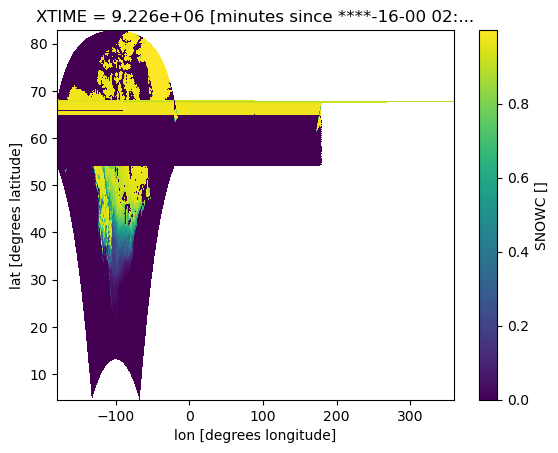

In [30]:
a=curvi_grid(WRF,reproj='WRF',geo_file=geo)
a['SNOWC'].sel(month=1).plot(x='lon',y='lat')

In [32]:
b=curvi_grid(Polar,reproj='Polar')
b

/home/p/peltier/edmundn/miniconda3/envs/ccia_wrf/lib/python3.11/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/p/peltier/edmundn/miniconda3/envs/ccia_wrf/lib/python3.11/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/tmp/ipykernel_134280/4285606191.py:33: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgradin

<xarray.Dataset> Size: 47GB
Dimensions:               (time: 2249, y: 1024, x: 1024)
Coordinates:
  * time                  (time) datetime64[ns] 18kB 1980-09-01 ... 2023-10-02
    snow_cover_threshold  float32 4B 0.5
    latitude              (y, x) float64 8MB 9.969e+36 9.969e+36 ... 9.969e+36
    longitude             (y, x) float64 8MB 9.969e+36 9.969e+36 ... 9.969e+36
  * x                     (x) float32 4kB -1.211e+04 -1.209e+04 ... 1.211e+04
  * y                     (y) float32 4kB 1.211e+04 1.209e+04 ... -1.211e+04
    lat                   (x, y) float64 8MB -18.63 -18.58 ... -18.58 -18.63
    lon                   (x, y) float64 8MB 180.0 -179.9 ... 0.05664 0.0005746
Data variables:
    polar_stereographic   (time, y, x) float64 19GB nan nan nan ... nan nan nan
    land                  (y, x, time) float32 9GB nan nan nan ... nan nan nan
    area                  (y, x, time) float32 9GB nan nan nan ... nan nan nan
    snow_cover_extent     (time, y, x) float32 9GB nan nan nan ... nan nan nan
Attributes: (12/38)
    Conventions:               CF-1.7, ACDD-1.3
    title:                     Rutgers Northern Hemisphere (NH) 24km Weekly S...
    summary:                   The data record for the Rutgers NH 24km Weekly...
    keywords:                  EARTH SCIENCE > CRYOSPHERE > SNOW/ICE > SNOW C...
    keywords_vocabulary:       NASA Global Change Master Directory (GCMD) Key...
    creator_name:              Global Snow Lab, Center for Environmental Pred...
    ...                        ...
    publisher_url:             https://nsidc.org
    metadata_link:             https://nsidc.org/data/G10035
    naming_authority:          org.nsidc
    references:                https://doi.org/10.7265/zzbm-2w05
    source:                    NOAA NH Weekly SCE, NIC NH IMS SCE
    comment:                   NOAA NH weekly SCE maps (September 1980 to May...